In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from random import choice

import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold

from plot_metricas import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f'Device: {device}')
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

Device: cuda
NVIDIA GeForce RTX 3050 Laptop GPU


### Treinamento

In [11]:
# Carregando os dados
data = pd.read_csv('features.csv')

# Separando os dados em X e y
X = data.drop('Classe', axis=1).values
y = data['Classe'].values

# Convertendo as labels para 0 e 1 com um dict
labels = {'Aleatória': 0, 'Humana': 1}
y = [labels[item] for item in y]

In [12]:
class DeepNeuralNetwork(nn.Module):
    def __init__(self):
        super(DeepNeuralNetwork, self).__init__()
        
        # Salvar os parâmetros de normalização
        self.norm_params = None

        '''
        Arquitetura:
        - Fully Connected
        - n_features x 64 com Normalização de Lote e Dropout de 0.1 e LeakyReLU
        - 64 x 32 com Normalização de Lote e Dropout de 0.1 e LeakyReLU
        - 32 x 16 com Normalização de Lote e Dropout de 0.1 e LeakyReLU
        - 16 x 1 com Sigmoid (para obter a probabilidade/confiança)
        '''
        
        self.fc1 = nn.Linear(X.shape[1], 64)
        # Batch Normalization: Normalizar os dados para evitar overfitting
        self.bn1 = nn.BatchNorm1d(64)

        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        
        self.fc3 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)

        self.fc4 = nn.Linear(16, 1)

        # Dropout: Desligar neurônios aleatoriamente para evitar overfitting
        self.dropout = nn.Dropout(0.1)
        
        # Inicialização dos pesos e bias com Kaiming Uniform
        self.apply(self.init_weights)

    # Feed Forward
    def forward(self, x):
        x = self.dropout(F.leaky_relu(self.bn1(self.fc1(x))))
        x = self.dropout(F.leaky_relu(self.bn2(self.fc2(x))))
        x = self.dropout(F.leaky_relu(self.bn3(self.fc3(x))))

        x = torch.sigmoid(self.fc4(x))
        return x
    
    # Inicialização dos pesos e bias com Kaiming Uniform
    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)

Fold 1

              precision    recall  f1-score   support

     Máquina       0.76      0.83      0.80       124
      Humana       0.78      0.70      0.74       106

    accuracy                           0.77       230
   macro avg       0.77      0.76      0.77       230
weighted avg       0.77      0.77      0.77       230



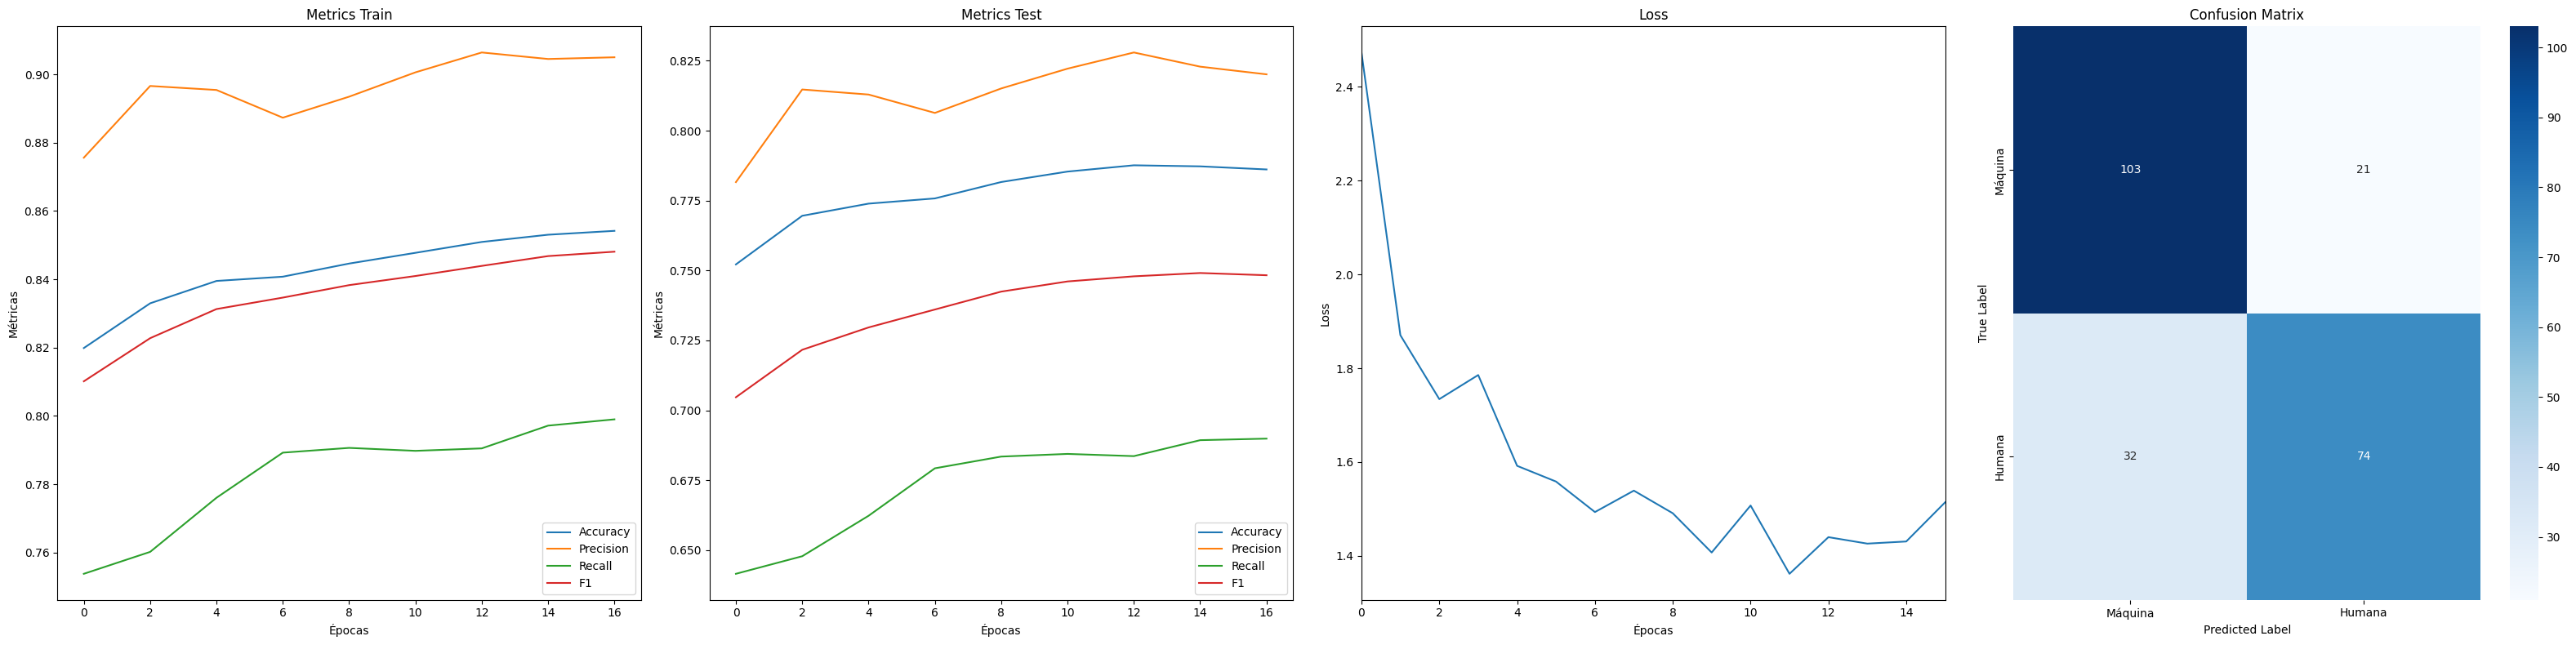

Fold 2

              precision    recall  f1-score   support

     Máquina       0.74      0.94      0.83       102
      Humana       0.94      0.73      0.82       127

    accuracy                           0.83       229
   macro avg       0.84      0.84      0.83       229
weighted avg       0.85      0.83      0.83       229



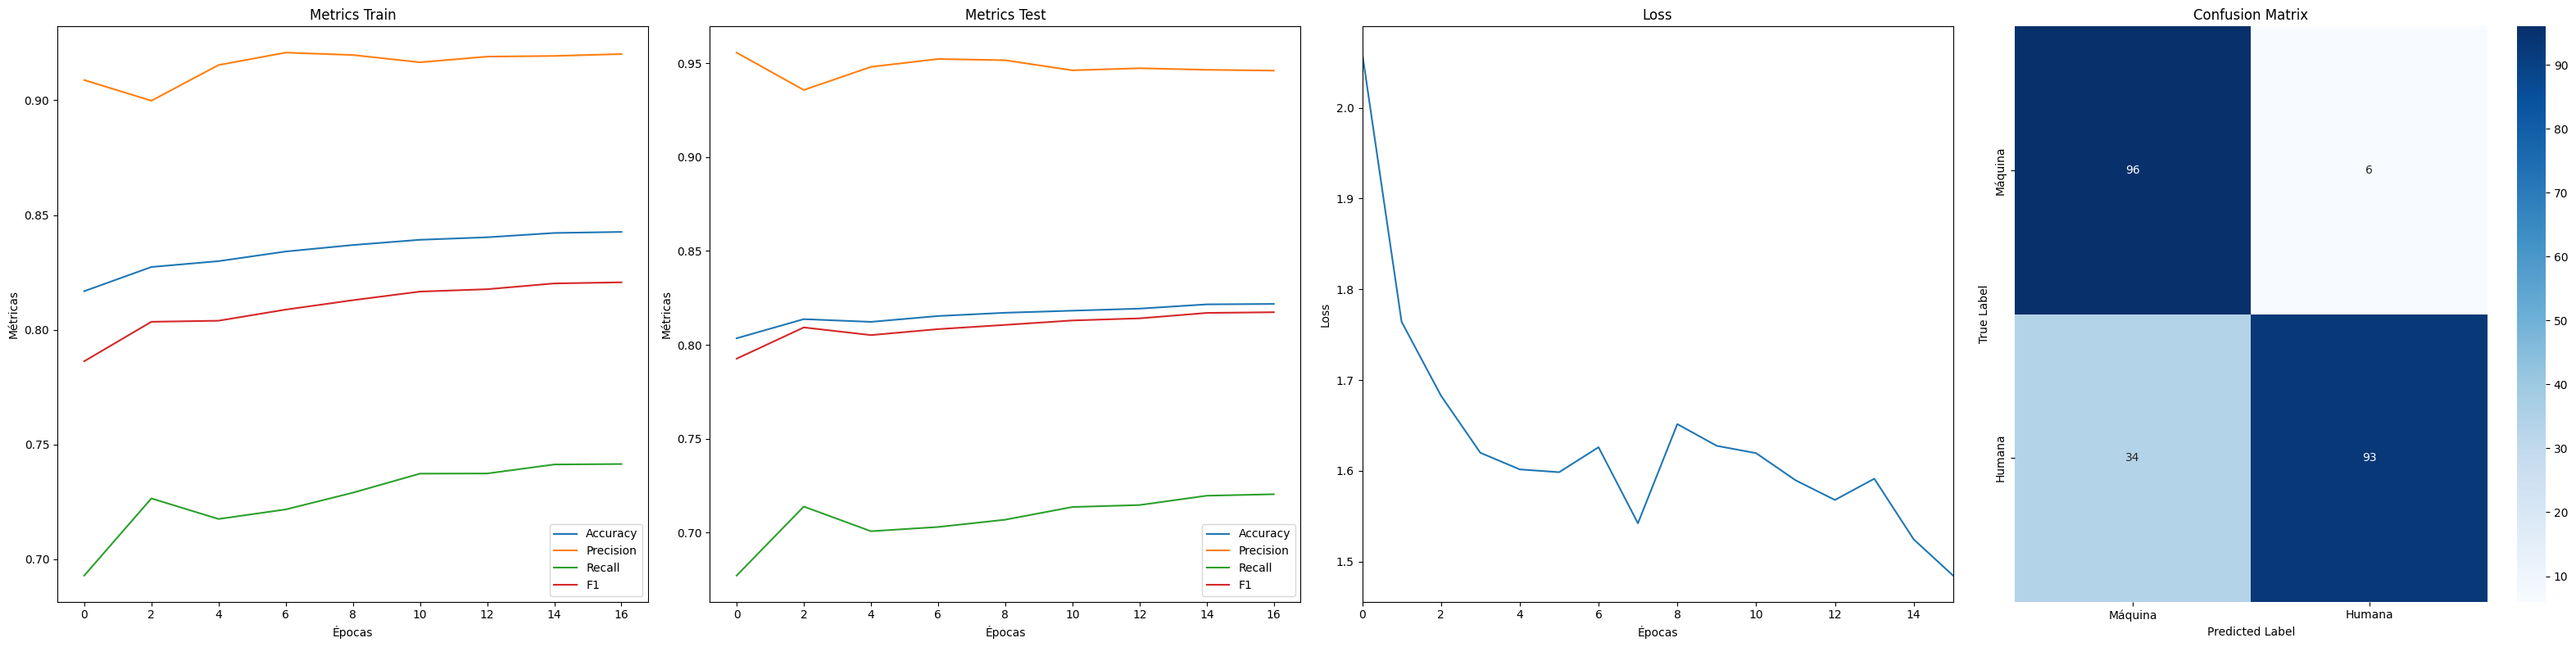

Fold 3

              precision    recall  f1-score   support

     Máquina       0.80      0.87      0.83       115
      Humana       0.86      0.78      0.82       114

    accuracy                           0.83       229
   macro avg       0.83      0.83      0.82       229
weighted avg       0.83      0.83      0.82       229



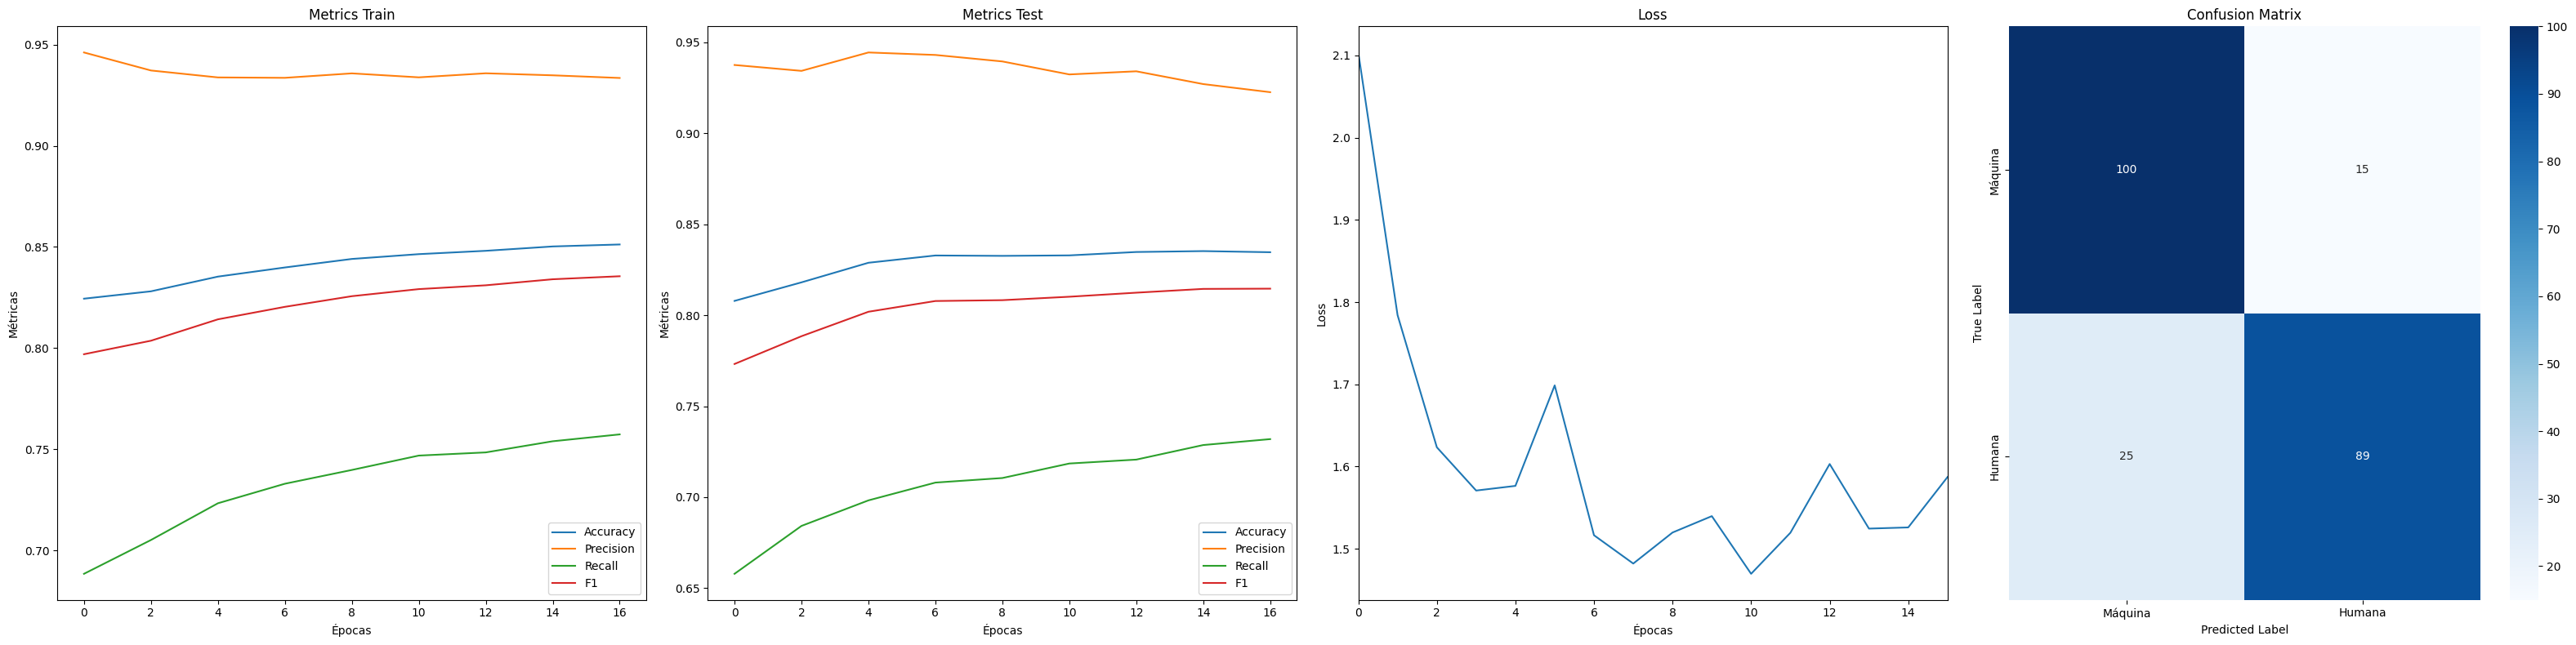

Fold 4

              precision    recall  f1-score   support

     Máquina       0.85      0.89      0.87       120
      Humana       0.87      0.83      0.85       109

    accuracy                           0.86       229
   macro avg       0.86      0.86      0.86       229
weighted avg       0.86      0.86      0.86       229



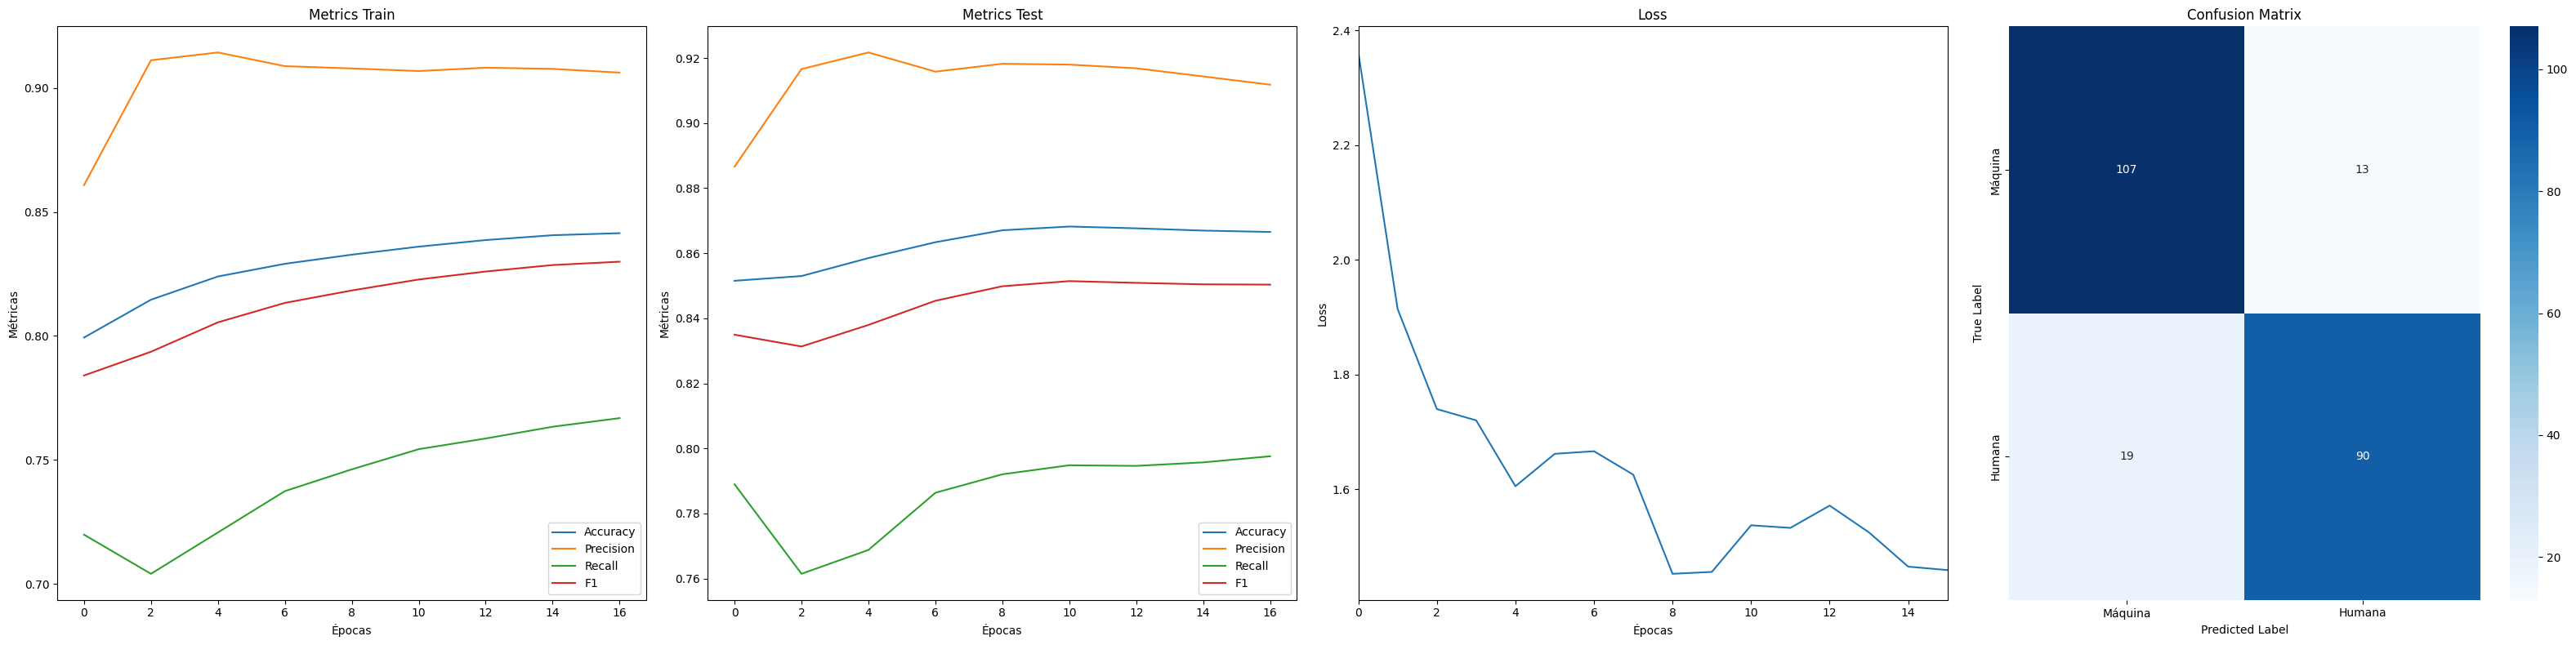

Fold 5

              precision    recall  f1-score   support

     Máquina       0.86      0.88      0.87       112
      Humana       0.88      0.86      0.87       117

    accuracy                           0.87       229
   macro avg       0.87      0.87      0.87       229
weighted avg       0.87      0.87      0.87       229



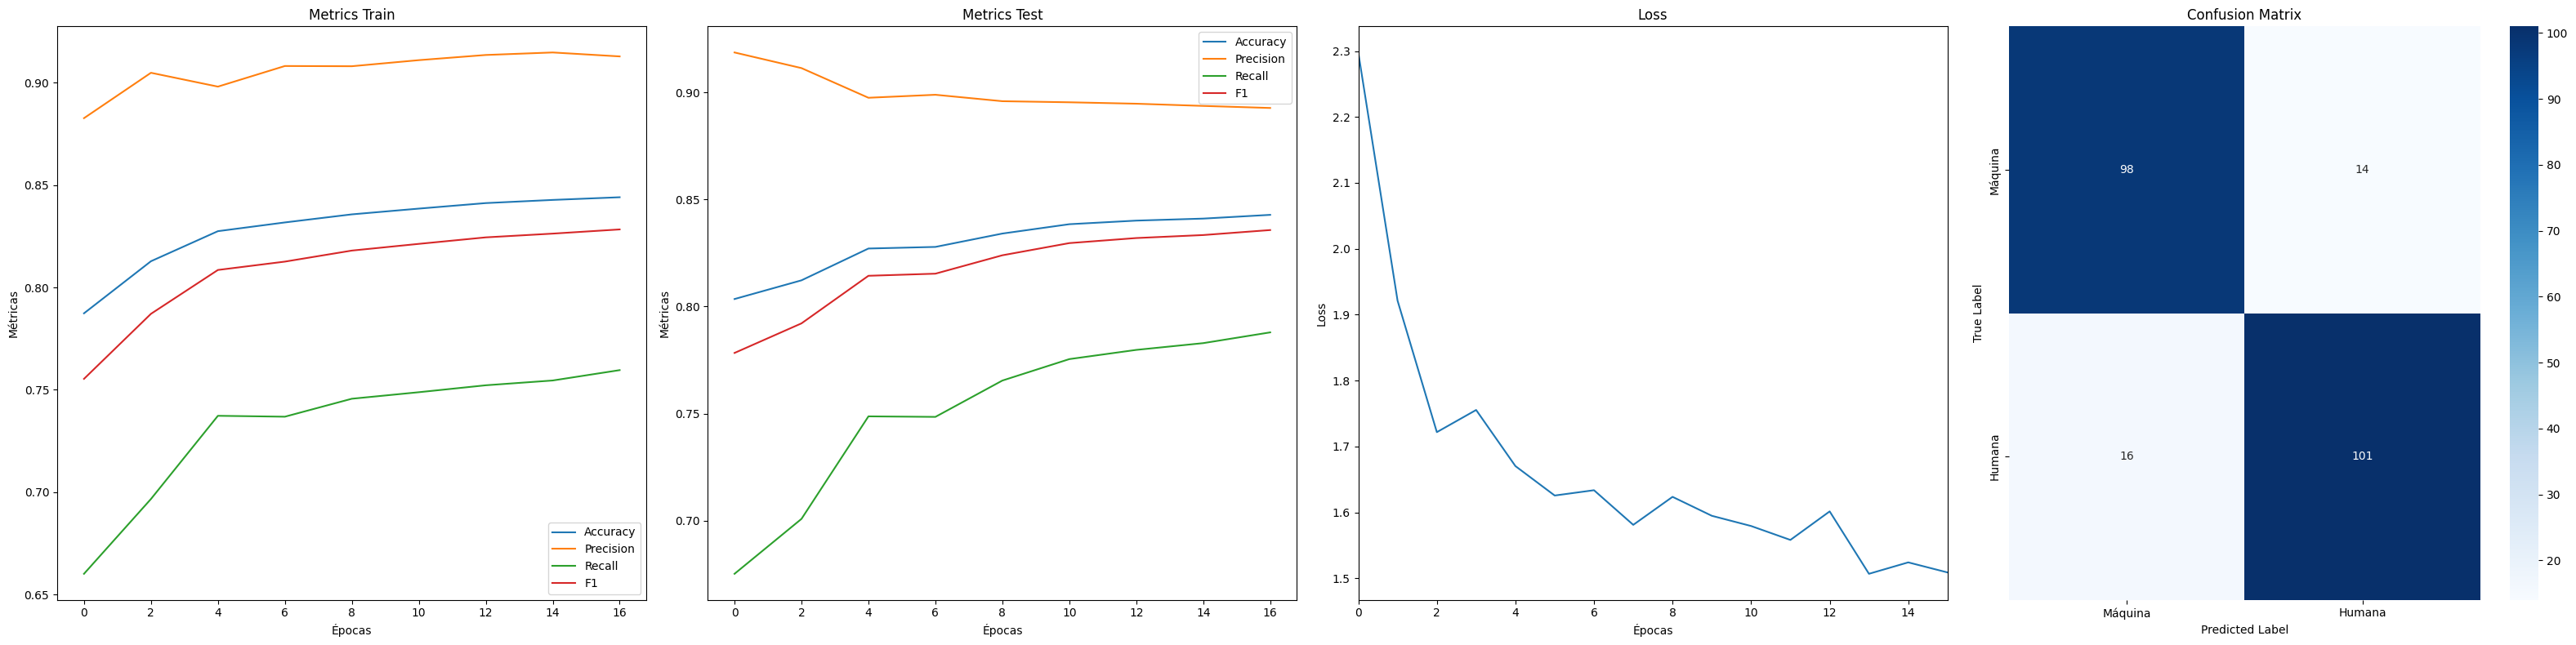


Média das métricas de todos os folds:
0: {'precision': 0.8596491228070176, 'recall': 0.875, 'f1-score': 0.8672566371681416, 'support': 112.0}
1: {'precision': 0.8782608695652174, 'recall': 0.8632478632478633, 'f1-score': 0.8706896551724138, 'support': 117.0}
accuracy: 0.868995633187773
macro avg: {'precision': 0.8689549961861175, 'recall': 0.8691239316239316, 'f1-score': 0.8689731461702777, 'support': 229.0}
weighted avg: {'precision': 0.8691581811943948, 'recall': 0.868995633187773, 'f1-score': 0.8690106245327698, 'support': 229.0}


In [13]:
'''
Validação cruzada com K-Fold (K=5): 4 folds para treino e 1 fold para teste -> 80/20
Um 'fold' é uma divisão dos dados
'''

import os

k = 5

# Cria uma pasta para cada fold dentro de 'folds'
folds_dir = 'folds'
if not os.path.exists(folds_dir):
    os.mkdir(folds_dir)
for i in range(k):
    if not os.path.exists(f'{folds_dir}/{i+1}'):
        os.mkdir(f'{folds_dir}/{i+1}')

# Batch size: Quantidade de amostras que serão propagadas pela rede de uma vez
batch_size = 16

kf = KFold(n_splits=k, shuffle=True)

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    epochs = 16
    
    losses = []
    results = []
    y = np.array(y)
    
    metrics_train = {'acc': [], 'prec': [], 'rec': [], 'f1': []}
    metrics_test = {'acc': [], 'prec': [], 'rec': [], 'f1': []}

    print(f"Fold {fold+1}")
    
    train_idx = torch.from_numpy(train_idx)
    test_idx = torch.from_numpy(test_idx)
    X_train_kfold, y_train_kfold = X[train_idx], y[train_idx]
    X_test_kfold, y_test_kfold = X[test_idx], y[test_idx]
    
    # Salva os datasets de treino e teste para o fold atual em CSV
    df_train = pd.DataFrame(X_train_kfold, columns=data.columns[:-1])
    df_train['Classe'] = y_train_kfold
    
    df_test = pd.DataFrame(X_test_kfold, columns=data.columns[:-1])
    df_test['Classe'] = y_test_kfold
    
    df_train.to_csv(f'folds/{fold+1}/train-fold-{fold+1}.csv', index=False)
    df_test.to_csv(f'folds/{fold+1}/test-fold-{fold+1}.csv', index=False)
    
    # Define modelo e adiciona a normalização
    model = DeepNeuralNetwork().to(device)
    optimizer = torch.optim.Adam(model.parameters())
    loss_function = nn.BCELoss()
    
    # Salvando os parâmetros de normalização
    train_mins = np.amin(X_train_kfold, axis=0)
    train_maxes = np.amax(X_train_kfold, axis=0)
    norm_params = list(zip(train_mins, train_maxes))
    
    # Normalizar
    X_train_kfold = MinMax(X_train_kfold, train_mins, train_maxes)
    X_test_kfold = MinMax(X_test_kfold, train_mins, train_maxes)
    
    # Convertendo para tensor
    X_train_kfold = torch.tensor(X_train_kfold, dtype=torch.float32)
    y_train_kfold = torch.tensor(y_train_kfold, dtype=torch.float32).view(-1, 1)
    X_test_kfold = torch.tensor(X_test_kfold, dtype=torch.float32)
    y_test_kfold = torch.tensor(y_test_kfold, dtype=torch.float32).view(-1, 1)
    
    train_data_kfold = TensorDataset(X_train_kfold, y_train_kfold)
    train_loader_kfold = DataLoader(train_data_kfold, batch_size=batch_size, shuffle=True)
    
    test_data_kfold = TensorDataset(X_test_kfold, y_test_kfold)
    test_loader_kfold = DataLoader(test_data_kfold, batch_size=batch_size, shuffle=False)
    
    for epoch in range(epochs):
        epoch_loss = 0
        model.train()
        for X_batch, y_batch in train_loader_kfold:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = loss_function(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        # Cálculo das métricas de treinamento e teste
        acc_train, prec_train, rec_train, f1_train = calculate_metrics(model, train_loader_kfold)
        acc_test, prec_test, rec_test, f1_test = calculate_metrics(model, test_loader_kfold)

        # Armazenando métricas
        metrics_train['acc'].append(acc_train)
        metrics_train['prec'].append(prec_train)
        metrics_train['rec'].append(rec_train)
        metrics_train['f1'].append(f1_train)
        metrics_test['acc'].append(acc_test)
        metrics_test['prec'].append(prec_test)
        metrics_test['rec'].append(rec_test)
        metrics_test['f1'].append(f1_test)
        
        losses.append(epoch_loss/len(test_loader_kfold))

        '''if (epoch) % (epochs/4) == 0 or epoch == 0 or epoch == epochs-1:
            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {epoch_loss/len(train_loader):.4f}")
            print(f"   Train - Acc: {acc_train:.4f}, Prec: {prec_train:.4f}, Rec: {rec_train:.4f}, F1: {f1_train:.4f}")
            print(f"   Test - Acc: {acc_test:.4f}, Prec: {prec_test:.4f}, Rec: {rec_test:.4f}, F1: {f1_test:.4f}\n")'''
    
    model.eval()
    with torch.no_grad():
        y_pred_kfold = model(X_test_kfold.to(device))
        y_pred_class_kfold = (y_pred_kfold > 0.5).cpu().int().numpy()
        
        report = classification_report(y_test_kfold.cpu().int().numpy(), y_pred_class_kfold, output_dict=True, zero_division=0)
        results.append(report)
        
        print()
        print(classification_report(y_test_kfold.cpu().int().numpy(), y_pred_class_kfold, target_names=['Máquina', 'Humana']))
        
    # Salvar o modelo para o fold atual
    torch.save({
        'state_dict': model.state_dict(),
        'norm_params': norm_params
    }, f'folds/{fold+1}/modelo-fold-{fold+1}.pt')
        
    # Plotando os 4 gráficos
    metrics_train = plot_metrics(metrics_train, epochs)
    metrics_test = plot_metrics(metrics_test, epochs)
    plot_all(metrics_train, metrics_test, losses, y_test_kfold.cpu().int().numpy(), y_pred_class_kfold, epochs)
    
average_results = {}
for key in results[0].keys():
    if isinstance(results[0][key], dict):
        metric_average = {}
        for metric in results[0][key].keys():
            metric_average[metric] = np.mean([fold_result[key][metric] for fold_result in results])
        average_results[key] = metric_average
    else:
        average_results[key] = np.mean([fold_result[key] for fold_result in results])

print()
print(f'Média das métricas de todos os folds:')
for key, value in average_results.items():
    print(f"{key}: {value}")